In [1]:
%tensorflow_version 2.x
%load_ext tensorboard

import glob, math, os, re, sys, zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
from functools import reduce
from itertools import cycle
from datetime import datetime
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from IPython.display import display, HTML
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import Model
from keras.layers import BatchNormalization

## Authorize Google Drive

In [2]:
auth.authenticate_user()

## Setup & Install
Basic setup and install additional dependencies

In [3]:
# Some global variables and general settings
saved_model_dir = './saved_model'
tensorboard_logs = './logs'
pd.options.display.float_format = '{:.2f}'.format
sns.set_context('notebook')
nnet_tools_path = os.path.abspath('NNet')

def print_html(string, tag='span', color=None, size=None):
    size = f'font-size:{size};' if size else ''
    color = f'color:{color};' if color else ''
    display(HTML(f'<{tag} style="{color}{size}">{string}</{tag}>'))

def print_heading(string, color=None):
    print_html(string, tag='h3', color=color)

def print_message(string, color=None):
    print_html(string, color=color)

def download_file_from_gdrive(gdrive_id, output_file):
    # Authenticate google drive
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    # Download csv from GDrive...
    dataset = drive.CreateFile({'id': gdrive_id})
    dataset_filename = dataset['title']
    print_message(f'Downloading {dataset_filename} ({gdrive_id}) from GDrive. Please wait...')
    dataset.GetContentFile(output_file)
    print_message(f'Download {gdrive_id} completed.')

def download_and_unzip(src_url, out_dir='./', zip_file='dl.zip', remove_zip=True):
    print(f'Downloading {src_url} to {zip_file}')
    !wget $src_url -O $zip_file -q --show-progress
    print(f'Download complete. Unzipping {zip_file}')
    z = zipfile.ZipFile(zip_file, 'r')
    z.extractall(out_dir)
    print(f'Unzipped to {out_dir}. Cleaning up...')
    z.close()
    if remove_zip: os.remove(zip_file)

def overwrite_gdrive_file(gdrive_id, input_file):
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    drive_file = drive.CreateFile({'id': gdrive_id})
    drive_file.SetContentFile(input_file)
    drive_file.Upload()
    drive_filename = drive_file['title']
    print(f'Wrote {input_file} to GDrive {drive_filename} ({gdrive_id}).')

def update_path_vars(paths=[]):
    python_path = os.environ.get('PYTHONPATH') or ''
    jupyter_path = os.environ.get('JUPYTER_PATH') or ''
    for path in paths:
        if not path in python_path:
            python_path += f':{path}'
        if not path in jupyter_path:
            jupyter_path += f':{path}'
    os.environ['PYTHONPATH'] = python_path
    os.environ['JUPYTER_PATH'] = jupyter_path

def install_nnet_tools(nnet_tools_path):
    nnet_tools_url = 'https://github.com/sisl/NNet/archive/master.zip'
    download_and_unzip(nnet_tools_url)
    !mv ./NNet-master $nnet_tools_path

def setup_nnet_tools(nnet_tools_path):
    # install nnet tools if not already installed.
    if not os.path.exists(nnet_tools_path):
        install_nnet_tools(nnet_tools_path)
    # add folder to PYTHONPATH & JUPYTER_PATH
    update_path_vars([nnet_tools_path])

# delete sample data
!rm -rf sample_data

# setup nnet tools (for converting model to Stanford's nnet format)
setup_nnet_tools(nnet_tools_path)
# used for conversion to NNet format
from NNet.utils.writeNNet import writeNNet

dl.zip                  [ <=>                ] 359.66K  --.-KB/s    in 0.1s    
Download complete. Unzipping dl.zip
Unzipped to ./. Cleaning up...


## Download Dataset

In [4]:
# GDrive ID of csv file (AllData_ReactionTime.csv)
# https://drive.google.com/file/d/1vNT9PopDTy7nUsedAHdg1-VFAKrk6PIO
gdrive_id='1vNT9PopDTy7nUsedAHdg1-VFAKrk6PIO'
dataset_file='all_data_rt.csv'

# load the dataset from gdrive if it doesn't exist in the runtime's filesystem.
if not os.path.exists(dataset_file):
    download_file_from_gdrive(gdrive_id, dataset_file)

## Import Dataset

In [5]:
raw_columns = ['ID', 'Name', 'FixationDuration', 'FixationSeq', 'FixationStart', 
               'FixationX', 'FixationY', 'GazeDirectionLeftZ', 'GazeDirectionRightZ', 
               'PupilLeft', 'PupilRight', 'InterpolatedGazeX', 'InterpolatedGazeY', 
               'AutoThrottle', 'AutoWheel', 'CurrentThrottle', 'CurrentWheel', 
               'Distance3D', 'MPH', 'ManualBrake', 'ManualThrottle', 'ManualWheel', 
               'RangeW', 'RightLaneDist', 'RightLaneType', 'LeftLaneDist', 'LeftLaneType', 
               'ReactionTime']
raw_df = pd.read_csv(dataset_file, usecols=raw_columns)
raw_df.set_index(['ID'], inplace=True)

In [6]:
# 5 class using mean & sdev
def create_tot_categories(rt_column):
    rt_mean = round(rt_column.mean())
    rt_sdev = round(rt_column.std())
    bound_1 = rt_mean - rt_sdev
    bound_2 = rt_mean - rt_sdev // 2
    bound_3 = rt_mean + rt_sdev // 2
    bound_4 = rt_mean + rt_sdev
    bins = [float('-inf'), bound_1, bound_2, bound_3, bound_4, float('inf')]
    labels =  np.array(['fast', 'med_fast', 'med', 'med_slow', 'slow'], dtype=object)
    return (bins, labels)

In [19]:
# make a copy the raw data
df = raw_df.copy()

# compute 'TOT' categories
tot_bins, tot_labels = create_tot_categories(df.ReactionTime)

In [20]:
# add the class to the dataframe
df['TOT'] = pd.cut(df.ReactionTime, bins=tot_bins, labels=tot_labels)

In [21]:
df['Name'].unique()

array(['018_M3', '018_M1', '017_M3', '017_M2', '017_M1', '016_M3',
       '016_M2', '016_M1', '015_M3', '015_m2', '015_M1', '014_M3',
       '014_M2', '014_m1', '013_M3', '013_M2', '013_M1', '012_M3',
       '012_M2', '012_M1', '011_M3', '011_M2', '011_M1', '010_M3',
       '010_M2', '010_M1', '009_M3', '009_M2', '009_M1', '008_M3',
       '008_M2', '008_M1', '007_M3', '007_M2', '007_M1', '006_M3',
       '006_M2', '006_M1', '005_M3', '005_M2', '005_M1', '004_M3',
       '004_M2', '004_M1'], dtype=object)

In [22]:
# Copy of the dataframe before exclusion of driver data
# In actuality, full_data would be the new driver's data added to existing data
full_data = df

### Subset for resource conservation. No need to run the cell immediately below.

In [14]:
chunk_users = ['015_M3', '015_m2', '015_M1', '014_M3', '014_M2', '014_m1']
df1 = df.loc[df['Name'].isin(chunk_users)]
print('Shape:', df1.shape)
df1['Name'].unique()

Shape: (814347, 28)


array(['015_M3', '015_m2', '015_M1', '014_M3', '014_M2', '014_m1'],
      dtype=object)

In [23]:
'''
JOHN'S CODE
# Select a handful of ppl for saving resource
chunk_users = ['015_M3', '015_m2', '015_M1', '014_M3', '014_M2', '014_m1']
unused_df = df.loc[~df['Name'].isin(chunk_users)]
df = df.loc[df['Name'].isin(chunk_users)]

# # convert datatypes for a few columns
df.RightLaneType = df.RightLaneType.astype(int)
df.LeftLaneType = df.LeftLaneType.astype(int)
df.TOT = df.TOT.astype(object)
'''
df.RightLaneType = df.RightLaneType.astype(int)
df.LeftLaneType = df.LeftLaneType.astype(int)
df.TOT = df.TOT.astype(object)

#Personalization dataset for new driver
#Example: new driver here is driver number 13 
new_driver = ['013_M1','013_M2','013_M3']
# d16_vals = ['015_M3', '015_m2', '015_M1', '014_M3', '014_M2', '014_m1','016_M1','016_M2','016_M3']
# driv16_df = df.loc[df['Name'].isin(d16_vals)]

#Selecting new driver's data from full dataset.
only_new = df.loc[df['Name'].isin(new_driver)]
ids_new = df['Name'].isin(new_driver)

#Dropping data concerning driver from main training dataset
df.drop(df[ids_new].index, inplace= True)


In [24]:
#This will be the data used for training the baseline model
df['Name'].unique()

array(['018_M3', '018_M1', '017_M3', '017_M2', '017_M1', '016_M3',
       '016_M2', '016_M1', '015_M3', '015_m2', '015_M1', '014_M3',
       '014_M2', '014_m1', '012_M3', '012_M2', '012_M1', '011_M3',
       '011_M2', '011_M1', '010_M3', '010_M2', '010_M1', '009_M3',
       '009_M2', '009_M1', '008_M3', '008_M2', '008_M1', '007_M3',
       '007_M2', '007_M1', '006_M3', '006_M2', '006_M1', '005_M3',
       '005_M2', '005_M1', '004_M3', '004_M2', '004_M1'], dtype=object)

In [25]:
print('Full dataframe without new driver data',df.shape,'\n\n','New driver dataframe',only_new.shape)

Full dataframe without new driver data (5528182, 28) 

 New driver dataframe (380929, 28)


### Helper Functions

In [27]:
def upsample_minority_TOTs(X_train, y_train, tot_labels, random_state=27):
    # contat the training data together.
    X = pd.concat([X_train, y_train], axis=1)
    # separate majority and minority classes
    buckets = {l: X[X.TOT == l] for l in tot_labels}
    maj_label, majority = reduce(lambda a,b: b if b[1].shape[0] > a[1].shape[0] else a, buckets.items())
    minorities = {k:v for k,v in buckets.items() if k != maj_label}
    # upsample the minority classes
    for k,v in minorities.items():
        buckets[k] = resample(v, replace=True, n_samples=majority.shape[0], random_state=random_state)
    upsampled = pd.concat(buckets.values()).sample(frac=1)
    # split the upsampled data into X and y
    y_train = upsampled['TOT']
    X_train = upsampled.drop('TOT', axis=1)
    return X_train, y_train

def prepare_inputs(X_train, X_test):
    # scales inputs using "standard scaler", and returns 2D numpy array
    scaler = StandardScaler().fit(pd.concat([X_train, X_test]))
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return X_train, X_test, scaler

def prepare_target(y_train, y_test, categories):
    # convert target to categorical, and returns 2D numpy array
    y_train = y_train.to_numpy().reshape(-1,1)
    y_test = y_test.to_numpy().reshape(-1,1)
    onehot = OneHotEncoder(categories=categories)
    onehot.fit(np.concatenate([y_train, y_test]))
    y_train = onehot.transform(y_train).toarray()
    y_test = onehot.transform(y_test).toarray()
    return y_train, y_test, onehot



**Transfer learning modifications:**
1. For training baseline model perform an 80-20 train test split.
2. New architecture will be trained on only new driver's data

**Creating the training and testing data for baseline model as well as the personalized model**

In [29]:
#split features and targets

# y= Labels excluding new driver
y = df.TOT
#y_new = Only new driver's labels
y_new = only_new.TOT
#y_full = full data labels(including all drivers)
y_full = full_data.TOT

#X = baseline data excluding new driver
X = df.drop(['Name', 'ReactionTime', 'TOT'], axis=1)
#X_new = Only new driver's data
X_new = only_new.drop(['Name', 'ReactionTime', 'TOT'], axis=1)
#X_full = All driver's data, including new driver
X_full = full_data.drop(['Name', 'ReactionTime', 'TOT'], axis=1)

# make results easier to reproduce
random_state = 27

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)
#Splitting new driver data into train and test
Xnew_train, Xnew_test, ynew_train, ynew_test = train_test_split(X_new, y_new, test_size=0.20, stratify=y_new, random_state=random_state)
#Split full data
Xf_train,Xf_test,yf_train,yf_test = train_test_split(X_full, y_full, test_size=0.20, stratify=y_full, random_state=random_state)

#Upsampling the training data
X_train, y_train = upsample_minority_TOTs(X_train, y_train, tot_labels)
#Upsampling driver 16's data
Xnew_train, ynew_train = upsample_minority_TOTs(Xnew_train, ynew_train, tot_labels)
#Upsampling full data
Xf_train, yf_train = upsample_minority_TOTs(Xf_train, yf_train, tot_labels)


#scale the inputs
X_train_enc, X_test_enc, scaler_base = prepare_inputs(X_train, X_test)
#scale the inputs of new driver 
Xnew_train_enc, Xnew_test_enc, scaler_16 = prepare_inputs(Xnew_train, Xnew_test)
#scale the inputs of full data
Xf_train_enc, Xf_test_enc, scaler_full = prepare_inputs(Xf_train, Xf_test)


# categorize outputs
y_train_enc, y_test_enc, onehot_base = prepare_target(y_train, y_test, categories=[tot_labels])
# categorize outputs
ynew_train_enc, ynew_test_enc, onehot_new = prepare_target(ynew_train, ynew_test, categories=[tot_labels])
# categorize outputs
yf_train_enc,yf_test_enc, onehot_full = prepare_target(yf_train, yf_test, categories=[tot_labels])


print_heading('TOT Value Counts')
print(y_train.value_counts())
print(ynew_train.value_counts())

med_slow    1268697
slow        1268697
med_fast    1268697
fast        1268697
med         1268697
Name: TOT, dtype: int64
med_fast    125586
med         125586
fast        125586
med_slow    125586
slow        125586
Name: TOT, dtype: int64


In [30]:
# save the column names & indexes for use during verification
feature_names = list(X.columns)

# display the feature names
print_heading('Feature Names')
print_message(feature_names)

# print the TOT categories
print_heading('TOT Categories')
print('\n'.join(['%s: %9.2f, %7.2f' % (tot_labels[i].rjust(8), tot_bins[i], tot_bins[i+1]) for i in range(5)]))

    fast:      -inf, 1612.00
med_fast:   1612.00, 2802.00
     med:   2802.00, 5180.00
med_slow:   5180.00, 6370.00
    slow:   6370.00,     inf


In [34]:
def display_processed_data(unencoded=True, encoded=True, describe=True):
    if unencoded:
        print_heading('Unencoded Data')
        display(pd.concat([X_train, y_train], axis=1).describe())
        
    if encoded:
        enc_tot_labels = onehot_base.get_feature_names(input_features=['TOT'])
        print_heading('Encoded Data')
        display(pd.concat([pd.DataFrame(X_train_enc, columns=X_train.columns),
                           pd.DataFrame(y_train_enc, columns=enc_tot_labels)],
                          axis=1).astype({k:int for k in enc_tot_labels}).describe())
display_processed_data()

,FixationDuration,FixationSeq,FixationStart,FixationX,FixationY,GazeDirectionLeftZ,GazeDirectionRightZ,PupilLeft,PupilRight,InterpolatedGazeX,InterpolatedGazeY,AutoThrottle,AutoWheel,CurrentThrottle,CurrentWheel,Distance3D,MPH,ManualBrake,ManualThrottle,ManualWheel,RangeW,RightLaneDist,RightLaneType,LeftLaneDist,LeftLaneType
count,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00
mean,638.85,947.02,515842.81,890.97,436.08,0.84,0.81,4.55,4.60,774.59,400.50,17.51,3.45,17.09,3.23,643.57,33.72,4.99,2.31,-1.81,0.41,1.73,2.89,1.76,1.05
std,802.90,472.63,247022.26,246.13,169.69,0.28,0.30,0.78,0.74,441.37,273.33,2.50,90.90,6.40,35.35,893.45,5.02,14.99,10.67,4.86,5.70,0.32,0.46,0.32,0.23
min,100.00,1.00,10.00,0.00,0.00,-0.22,-0.49,1.74,1.62,-1.00,-1.00,15.00,-3799.00,0.00,-3707.00,0.00,0.00,0.00,0.00,-90.00,0.00,0.00,0.00,0.00,0.00
25%,294.00,755.00,447943.00,897.00,416.00,0.86,0.83,3.90,4.00,680.00,170.00,15.00,-13.00,15.00,-12.00,388.35,33.49,0.00,0.00,-4.00,0.00,1.60,3.00,1.65,1.00
50%,650.25,928.29,506955.49,897.00,435.27,0.94,0.94,4.65,4.93,901.00,430.00,20.00,0.00,15.00,0.00,683.20,35.00,0.00,0.00,-1.00,0.00,1.75,3.00,1.75,1.00
75%,650.25,1039.00,589769.00,953.00,481.00,0.98,0.98,5.00,5.00,1031.00,588.00,20.00,29.00,20.00,23.00,696.80,35.05,0.00,0.00,1.00,0.00,1.85,3.00,1.90,1.00
max,15444.00,2554.00,1208913.00,1915.00,1077.00,1.00,1.00,7.50,8.50,1919.00,1079.00,20.00,4049.00,100.00,755.00,132550.50,59.16,100.00,100.00,90.00,131.00,4.39,3.00,9.90,3.00


,FixationDuration,FixationSeq,FixationStart,FixationX,FixationY,GazeDirectionLeftZ,GazeDirectionRightZ,PupilLeft,PupilRight,InterpolatedGazeX,InterpolatedGazeY,AutoThrottle,AutoWheel,CurrentThrottle,CurrentWheel,Distance3D,MPH,ManualBrake,ManualThrottle,ManualWheel,RangeW,RightLaneDist,RightLaneType,LeftLaneDist,LeftLaneType,TOT_fast,TOT_med_fast,TOT_med,TOT_med_slow,TOT_slow
count,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00,6343485.00
mean,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.20,0.20,0.20,0.20,0.20
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,1.00,1.01,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.40,0.40,0.40,0.40,0.40
min,-0.67,-2.01,-2.09,-3.63,-2.58,-3.83,-4.32,-3.61,-3.98,-1.76,-1.47,-1.00,-41.87,-2.67,-104.90,-0.71,-6.72,-0.33,-0.22,-18.12,-0.07,-5.44,-6.29,-5.54,-4.53,0.00,0.00,0.00,0.00,0.00
25%,-0.43,-0.41,-0.27,0.02,-0.12,0.06,0.05,-0.84,-0.80,-0.22,-0.85,-1.00,-0.18,-0.33,-0.43,-0.28,-0.05,-0.33,-0.22,-0.45,-0.07,-0.42,0.24,-0.37,-0.23,0.00,0.00,0.00,0.00,0.00
50%,0.02,-0.04,-0.03,0.02,-0.01,0.34,0.42,0.13,0.44,0.28,0.11,1.00,-0.04,-0.33,-0.09,0.04,0.25,-0.33,-0.22,0.17,-0.07,0.05,0.24,-0.04,-0.23,0.00,0.00,0.00,0.00,0.00
75%,0.02,0.20,0.30,0.25,0.26,0.51,0.55,0.58,0.54,0.58,0.69,1.00,0.28,0.46,0.56,0.06,0.27,-0.33,-0.22,0.58,-0.07,0.38,0.24,0.43,-0.23,0.00,0.00,0.00,0.00,0.00
max,18.42,3.41,2.82,4.17,3.78,0.56,0.62,3.79,5.22,2.60,2.49,1.00,44.55,12.96,21.26,145.96,5.07,6.39,9.17,18.87,22.94,8.34,0.24,25.54,8.37,1.00,1.00,1.00,1.00,1.00



## Build & Train NN

**LR scheduler**

In [35]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=15, min_lr=0.0001)

In [36]:
#These callbacks are common to the baseline as well as modified architecture.
#cleanup the old training logs and models
!rm -rf $tensorboard_logs model-*.h5 $saved_model_dir

# training callbacks
mc_file = 'model-best-{epoch:02d}-{val_loss:.2f}.h5'
es_cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc_cb = ModelCheckpoint(mc_file, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
tb_cb = TensorBoard(log_dir=tensorboard_logs, histogram_freq=1, write_graph=True, write_images=True)

### Tried architectures

In [ ]:
#Baseline Neural Network

# build neural network

# v3.1.4 (28,14,8): accuracy ~0.9124, loss ~0.2079

# v3.2.0 - loss: 0.3543 - accuracy: 0.8639 - val_loss: 0.3481 - val_accuracy: 0.8650
# model = Sequential()
# model.add(InputLayer(input_shape=(X_train_enc.shape[1],)))
# model.add(Dense(28, activation='relu', kernel_initializer='he_normal'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(10, activation='relu'))
# model.add(Dense(5, activation='softmax')) # logits layer

# v3.2.1 - loss: 0.3444 - accuracy:  0.8661 - val_loss: 0.3348 - val_accuracy: 0.8699
# model = Sequential()
# model.add(InputLayer(input_shape=(X_train_enc.shape[1],)))
# model.add(Dense(23, activation='relu', kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(Dense(18, activation='relu'))
# model.add(Dense(11, activation='relu'))
# model.add(Dense(5, activation='softmax')) # logits layer

# model = Sequential()
# model.add(InputLayer(input_shape=(X_train_enc.shape[1],)))
# model.add(Dense(80, activation='relu', kernel_initializer='he_normal'))
# model.add(BatchNormalization())
# model.add(Dense(50, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(35, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(23, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(18, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(11, activation='relu'))
# model.add(Dense(5, activation='softmax')) # logits layer

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Experiment 3 with Baseline

In [ ]:
'''
Model architecture:
Input Neurons: 25(Number of features in each data point)
Hidden Layers: Dense layers with 50-100-35-11
Output Neurons: 5 (Number of classes)
'''
model = Sequential()
model.add(InputLayer(input_shape=(X_train_enc.shape[1],)))
model.add(Dense(50, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(100, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(11, activation='relu'))
model.add(Dense(5, activation='softmax')) # logits layer

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])



# fit the keras model on the dataset
history = model.fit(X_train_enc, y_train_enc,
                      validation_split=0.10,
                      epochs=200,
                      batch_size=512,
                      callbacks=[es_cb, mc_cb, tb_cb, reduce_lr])

# pick best model file from filesystem
best_model_path = sorted(glob.glob('model-best-*.h5'), key=lambda f: int(re.search(r'\d+', f).group()))[-1]

print_heading('Best Model:')
print_message(best_model_path)

# cleanup old model
!rm -rf $saved_model_dir

# save model in tf and h5 formats
tf_model_path = f'{saved_model_dir}/model'
h5_model_path = f'{saved_model_dir}/model.h5'
model.save(tf_model_path, save_format='tf')
model.save(h5_model_path, save_format='h5')

In [ ]:
model = load_model('model-best-190-0.49.h5')

**4-Hidden layer baseline being tested on data without driver 16**

In [ ]:
_, train_acc = model.evaluate(X_train_enc, y_train_enc, verbose=2)
_, test_acc = model.evaluate(X_test_enc, y_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

198234/198234 - 209s - loss: 0.6175 - accuracy: 0.7798
34552/34552 [==============================] - 50s 1ms/step - loss: 0.6223 - accuracy: 0.7687
Accuracy of test: 76.87
Accuracy of the: 1) Train: 0.780, 2) Test: 0.769


**4-Hidden layer baseline being tested on data without driver 17**

In [ ]:
_, train_acc = model.evaluate(X_train_enc, y_train_enc, verbose=2)
_, test_acc = model.evaluate(X_test_enc, y_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

197383/197383 - 214s - loss: 0.4847 - accuracy: 0.8207
34386/34386 [==============================] - 53s 2ms/step - loss: 0.5168 - accuracy: 0.8062
Accuracy of test: 80.62
Accuracy of the: 1) Train: 0.821, 2) Test: 0.806


In [ ]:

old_model = load_model('model-best-190-0.49.h5')

In [ ]:
old_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 35)                3535      
_________________________________________________________________
dense_3 (Dense)              (None, 11)                396       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 60        
Total params: 10,391
Trainable params: 10,391
Non-trainable params: 0
_________________________________________________________________


**Accuracy of the original model on driver 16's data**

In [ ]:
_, train_acc = old_model.evaluate(X16_train_enc, y16_train_enc, verbose=2)
_, test_acc = old_model.evaluate(X16_test_enc, y16_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

In [ ]:
# Load the best baseline architecture
#old_model = load_model('model-best-43-1.01.h5')

#Freeze the weights learnt by the baseline model
old_model.trainable = False

#Consider upto the penultimate layer of the network
old_model.pop()
old_model.pop()
#Verify the slice of the architecture
old_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 35)                3535      
Total params: 9,935
Trainable params: 0
Non-trainable params: 9,935
_________________________________________________________________


**Inserting additional layers in the baseline**
1. Create a dense layer which will take output of old_model as its input.
2. Add the final classification layer as per the baseline.

**A wider and deeper architecture for transfer learning**

In [ ]:
fc = Dense(50,activation= 'relu')(old_model.output)
fc2 = Dense(25,activation= 'relu')(fc)
fc3 = Dense(5,activation='softmax')(fc2)

model = Model(inputs = old_model.input, outputs = fc3)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 35)                3535      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1800      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 130 

**Training the modified architecture**
The training is done only on driver16 data

## Mod: Training the transfer layers now on full dataset

In [ ]:
# Experimenting on the full dataset
history = model.fit(Xf_train_enc, yf_train_enc,
                      validation_split=0.10,
                      epochs=80,
                      batch_size=512,
                      callbacks=[es_cb, mc_cb, tb_cb,reduce_lr])

Epoch 1/80
11151/11151 [==============================] - 23s 2ms/step - loss: 1.0462 - accuracy: 0.5792 - val_loss: 0.6815 - val_accuracy: 0.7404

Epoch 00001: val_loss improved from inf to 0.68148, saving model to model-best-01-0.68.h5
Epoch 2/80
11151/11151 [==============================] - 22s 2ms/step - loss: 0.6446 - accuracy: 0.7562 - val_loss: 0.5900 - val_accuracy: 0.7777

Epoch 00002: val_loss improved from 0.68148 to 0.58998, saving model to model-best-02-0.59.h5
Epoch 3/80
11151/11151 [==============================] - 22s 2ms/step - loss: 0.5840 - accuracy: 0.7796 - val_loss: 0.5634 - val_accuracy: 0.7879

Epoch 00003: val_loss improved from 0.58998 to 0.56337, saving model to model-best-03-0.56.h5
Epoch 4/80
11151/11151 [==============================] - 22s 2ms/step - loss: 0.5631 - accuracy: 0.7881 - val_loss: 0.5516 - val_accuracy: 0.7923

Epoch 00004: val_loss improved from 0.56337 to 0.55155, saving model to model-best-04-0.55.h5
Epoch 5/80
11151/11151 [============

In [ ]:
history = model.fit(Xnew_train_enc, ynew_train_enc,
                      validation_split=0.10,
                      epochs=50,
                      batch_size=512,
                      callbacks=[es_cb, mc_cb, tb_cb,reduce_lr])

Epoch 1/50
1104/1104 [==============================] - 2s 2ms/step - loss: 0.9816 - accuracy: 0.6498 - val_loss: 0.7782 - val_accuracy: 0.7080

Epoch 00001: val_loss did not improve from 0.50581
Epoch 2/50
1104/1104 [==============================] - 2s 2ms/step - loss: 0.7335 - accuracy: 0.7254 - val_loss: 0.7005 - val_accuracy: 0.7361

Epoch 00002: val_loss did not improve from 0.50581
Epoch 3/50
1104/1104 [==============================] - 2s 2ms/step - loss: 0.6757 - accuracy: 0.7475 - val_loss: 0.6582 - val_accuracy: 0.7534

Epoch 00003: val_loss did not improve from 0.50581
Epoch 4/50
1104/1104 [==============================] - 2s 2ms/step - loss: 0.6354 - accuracy: 0.7634 - val_loss: 0.6181 - val_accuracy: 0.7684

Epoch 00004: val_loss did not improve from 0.50581
Epoch 5/50
1104/1104 [==============================] - 2s 2ms/step - loss: 0.6032 - accuracy: 0.7759 - val_loss: 0.5891 - val_accuracy: 0.7813

Epoch 00005: val_loss did not improve from 0.50581
Epoch 6/50
1104/1104

KeyboardInterrupt: ignored

**Testing the model on driver 16's data**

In [ ]:
best_model = load_model('model-best-76-0.41.h5')

**Testing the model on driver 17's data**

In [ ]:
best_model = load_model('model-best-20-0.41.h5')

### Evaluate the model on new driver's data

In [ ]:
_, train_acc = best_model.evaluate(Xnew_train_enc, ynew_train_enc, verbose=2)
_, test_acc = best_model.evaluate(Xnew_test_enc, ynew_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

19623/19623 - 21s - loss: 0.4056 - accuracy: 0.8558
2381/2381 [==============================] - 3s 1ms/step - loss: 0.4731 - accuracy: 0.8176
Accuracy of test: 81.76
Accuracy of the: 1) Train: 0.856, 2) Test: 0.818


**Evaluate the model on driver 17's data**

In [ ]:
_, train_acc = best_model.evaluate(Xnew_train_enc, ynew_train_enc, verbose=2)
_, test_acc = best_model.evaluate(Xnew_test_enc, ynew_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

17653/17653 - 20s - loss: 0.1692 - accuracy: 0.9356
2547/2547 [==============================] - 4s 2ms/step - loss: 0.2329 - accuracy: 0.9040
Accuracy of test: 90.40
Accuracy of the: 1) Train: 0.936, 2) Test: 0.904


Evaluate the model on driver 14's data

In [ ]:
_, train_acc = best_model.evaluate(Xo16_train_enc, yo16_train_enc, verbose=2)
_, test_acc = best_model.evaluate(Xo16_test_enc, yo16_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

19134/19134 - 28s - loss: 0.4099 - accuracy: 0.8529
2484/2484 [==============================] - 5s 2ms/step - loss: 0.4590 - accuracy: 0.8309
Accuracy of test: 83.09
Accuracy of the: 1) Train: 0.853, 2) Test: 0.831


**Does it generalize at least a little?**

In [ ]:
_, train_acc = best_model.evaluate(X_train_enc, y_train_enc, verbose=2)
_, test_acc = best_model.evaluate(X_test_enc, y_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

198234/198234 - 213s - loss: 4.3559 - accuracy: 0.2912
34552/34552 [==============================] - 52s 1ms/step - loss: 3.7000 - accuracy: 0.3181
Accuracy of test: 31.81
Accuracy of the: 1) Train: 0.291, 2) Test: 0.318


### Following experiments belong to the old iteration. Best results of transfer learning are as shown above.

**Round of fine tuning of the entire architecture:**
Set the trainable flag for the old_model layers to be True again to perform a final round of fine tuning for the entire architecture.

In [ ]:
for layer in model.layers[:-2]:
  layer.trainable = True
  
history = model.fit(X_train_enc, y_train_enc,
                      validation_split=0.10,
                      epochs=8,
                      batch_size=16,
                      callbacks=[es_cb, mc_cb, tb_cb])

Epoch 1/8
368994/368994 [==============================] - 674s 2ms/step - loss: 1.0278 - accuracy: 0.5822 - val_loss: 1.0137 - val_accuracy: 0.5879

Epoch 00001: val_loss did not improve from 1.01223
Epoch 2/8
368994/368994 [==============================] - 674s 2ms/step - loss: 1.0138 - accuracy: 0.5870 - val_loss: 1.0088 - val_accuracy: 0.5898

Epoch 00002: val_loss improved from 1.01223 to 1.00877, saving model to model-best-02-1.01.h5
Epoch 3/8
368994/368994 [==============================] - 672s 2ms/step - loss: 1.0131 - accuracy: 0.5870 - val_loss: 1.0095 - val_accuracy: 0.5868

Epoch 00003: val_loss did not improve from 1.00877
Epoch 4/8
368994/368994 [==============================] - 673s 2ms/step - loss: 1.0126 - accuracy: 0.5867 - val_loss: 1.0082 - val_accuracy: 0.5873

Epoch 00004: val_loss improved from 1.00877 to 1.00817, saving model to model-best-04-1.01.h5
Epoch 5/8
368994/368994 [==============================] - 673s 2ms/step - loss: 1.0100 - accuracy: 0.5885 - v

**Accuracy of the transferred model on driver 16's data**

**Accuracy after fine tuning the entire model**

In [ ]:
_, train_acc = model.evaluate(X16_train_enc, y16_train_enc, verbose=2)
_, test_acc = model.evaluate(X16_test_enc, y16_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

23839/23839 - 26s - loss: 2.6160 - accuracy: 0.2102
2613/2613 [==============================] - 4s 1ms/step - loss: 2.9954 - accuracy: 0.2088
Accuracy of test: 20.88
Accuracy of the: 1) Train: 0.210, 2) Test: 0.209


In [ ]:
model.save('transfer.h5')

**Observations:**
1. Training accuracy increased from 87.4% to 87.6%
2. Test accuracy increased from 85.21% to 85.74% on unseen data

 **Baseline Architecture and Modified architecture:**

<img src = 'https://drive.google.com/uc?id=1khDy2rcmbPyIY941rrUAVai4GtaWWtCH' alt = 'Old_arch' width = '400' height = '320' >
 <img src = 'https://drive.google.com/uc?id=1MZO7IEX7-cBo7XmaDxNkNWwa8NsTEPme'alt = 'New_arch' width = '400' height = '320' >


 


    

In [ ]:
model.save('85.74test.h5', save_format='h5')

In [ ]:
print(model.summary())

33335/33335 - 24s - loss: 0.3318 - accuracy: 0.8740
5090/5090 [==============================] - 5s 896us/step - loss: 0.3756 - accuracy: 0.8521
Accuracy of test: 85.21
Accuracy of the: 1) Train: 0.874, 2) Test: 0.852


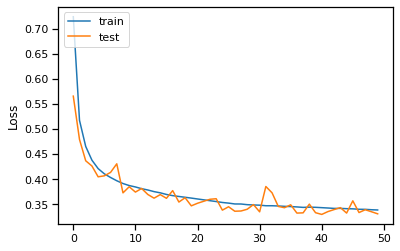

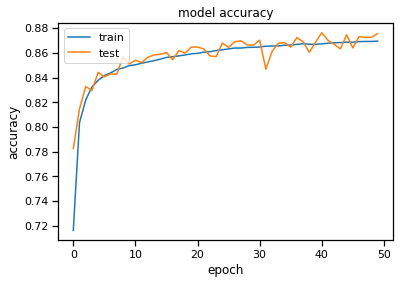

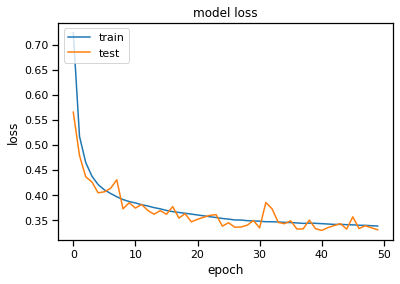

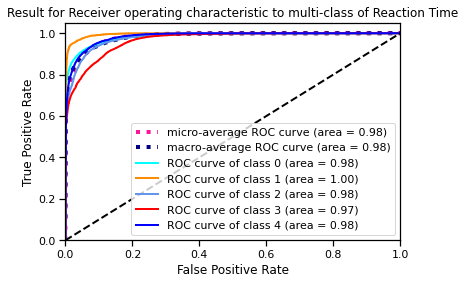

In [ ]:
print_heading(f'Evaluating {best_model_path}')

!mkdir -p images

# load the saved best model
saved_model = load_model(tf_model_path)

# evaluate the model
_, train_acc = saved_model.evaluate(X_train_enc, y_train_enc, verbose=2)
_, test_acc = saved_model.evaluate(X_test_enc, y_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('Loss')
plt.savefig('images/training_history.png', dpi=300)
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('images/accuracy_history.png', dpi=300)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('images/loss_history.png', dpi=300)
plt.show()

#note in kera model.predict() will return predict probabilities
pred_prob =  saved_model.predict(X_test_enc, verbose=0)
fpr, tpr, threshold = metrics.roc_curve(y_test_enc.ravel(), pred_prob.ravel())
roc_auc = metrics.auc(fpr, tpr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_enc[:,i], pred_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])    
   
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = metrics.roc_curve(y_test_enc.ravel(), pred_prob.ravel())
roc_auc['micro'] = metrics.auc(fpr['micro'], tpr['micro'])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 5

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = metrics.auc(fpr['macro'], tpr['macro'])

plt.figure(1)
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})' \
               ''.format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})' \
               ''.format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue'])
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})' \
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Result for Receiver operating characteristic to multi-class of Reaction Time')
plt.legend(loc='lower right')
plt.savefig('images/roc.png', dpi=300)
plt.show()

## Create Verification Artifacts


In [ ]:
def compute_nnet_params(model_file, df, scaler):
    outputs = df['TOT']
    inputs = df.drop(['Name', 'TOT', 'ReactionTime'], axis=1)
    enc_inputs = pd.DataFrame(scaler.transform(inputs.values), columns=inputs.columns)

    # compute sdev, mins, and maxs for inputs
    input_sdev = enc_inputs.std().to_numpy()
    input_mins = enc_inputs.min().to_numpy()
    input_maxs = enc_inputs.max().to_numpy()

    # extend input maxs and mins by std dev
    input_mins -= input_sdev
    input_maxs += input_sdev

    # maraboupy only supports normalization (not standardization)
    # use mean=0, and range=1 to neutralize maraboupy normalization
    means = np.zeros(enc_inputs.shape[1]+1, dtype=int) 
    ranges = np.ones(enc_inputs.shape[1]+1, dtype=int)

    # extract weights and biases from model
    model = load_model(model_file)
    model_params = model.get_weights()
    weights = [w.T for w in model_params[0:len(model_params):2]]
    biases  = model_params[1:len(model_params):2]

    return (weights, biases, input_mins, input_maxs, means, ranges)


def save_nnet(weights, biases, input_mins, input_maxs, means, ranges, output_path):
    # write model in nnet format.
    writeNNet(weights, biases, input_mins, input_maxs, means, ranges, output_path)

def save_info(weights, biases, input_mins, input_maxs, means, ranges, feature_names, tot_bins, tot_labels, output_path):
    def section(param_name, values):
        return ('-' * 40) + '\n' + f'{param_name}:\n{values}\n'
    
    tot_categories = '\n'.join([f'{tot_labels[i]}: ({tot_bins[i]}, {tot_bins[i+1]})' for i in range(len(tot_bins)-1)])
    input_nodes = ', '.join([f'{i}:{feature_names[i]}' for i in range(len(feature_names))])
    with open(output_path, 'w') as f:
        f.writelines([section('FEATURE_NAMES', feature_names),
                      section('INPUT_NODES', input_nodes),
                      section('TOT_CATEGORIES', tot_categories),
                      section('WEIGHTS', weights),
                      section('BIASES', biases),
                      section('MINS', input_mins),
                      section('MAXS', input_maxs),
                      section('MEANS', means),
                      section('RANGES', ranges)])

def save_encoders(scaler, onehot, output_dir):
    pkl.dump(scaler, open(f'{output_dir}/scaler.pkl', 'wb'))
    pkl.dump(onehot, open(f'{output_dir}/onehot.pkl', 'wb'))

def create_verification_artifacts(tf_model_path, h5_model_path, df, feature_names, tot_bins, tot_labels, scaler, onehot):
    print_heading(f'Creating verification artifacts...')
    output_dir='artifacts'
    archive_path = 'artifacts.zip'
    h5_path = os.path.join(output_dir, 'model.h5')
    pb_path = os.path.join(output_dir, 'model.pb')
    nnet_path = os.path.join(output_dir, 'model.nnet')
    info_path = os.path.join(output_dir, 'model.info')
    model_zip = os.path.join(output_dir, 'model.zip')

    # clear previous folder
    !rm -rf $output_dir
    # create the folder
    !mkdir -p $output_dir

    # zip up the tf model, and copy to artifacts
    !cd $tf_model_path/.. && zip -qr ../$model_zip model && cd - > /dev/null
    # copy the pb model file
    !cp $tf_model_path/saved_model.pb $pb_path
    # copy the h5 model file
    !cp $h5_model_path $h5_path
    # copy the images to artifacts
    !cp -r images $output_dir

    # extract params for nnet format
    nnet_params = compute_nnet_params(tf_model_path, df, scaler)
    weights, biases, input_mins, input_maxs, means, ranges = nnet_params
    # write the model to nnet file.
    save_nnet(weights, biases, input_mins, input_maxs, means, ranges, nnet_path)
    # write encoders to file
    save_encoders(scaler, onehot, output_dir)
    # save extra model information
    save_info(weights, biases, input_mins, input_maxs, means, ranges, featddure_names, tot_bins, tot_labels, info_path)
    # create a zip archive of artifacts
    !zip -rq $archive_path $output_dir
    print_message(f'Saved artifacts to {archive_path}')

# create artifacts used for verification
create_verification_artifacts(tf_model_path, h5_model_path, df, feature_names, tot_bins, tot_labels, scaler, onehot)

In [ ]:
def save_data(X_train_enc, X_test_enc, y_train_enc, y_test_enc, data_dir='data'):
    train_df = pd.concat([pd.DataFrame(X_train_enc), pd.DataFrame(y_train_enc)], axis=1)
    test_df = pd.concat([pd.DataFrame(X_test_enc), pd.DataFrame(y_test_enc)], axis=1)
    !mkdir -p $data_dir
    train_csv, test_csv = f'{data_dir}/train.csv', f'{data_dir}/test.csv'
    train_df.to_csv(train_csv)
    test_df.to_csv(test_csv)
    print(f'wrote data to {train_csv} and {test_csv}')

save_data(X_train_enc, X_test_enc, y_train_enc, y_test_enc)

## Save Model & Verification Artifacts to GDrive

In [ ]:
# # GDrive ID's point to files in models/latest folder
# artifacts = {
#     'artifacts/model.info': '1l59_JttOSA4rwy2a4-fnPkezfIoaULXp', # info file
#     'artifacts/model.zip': '100s5DVwaK6ILlDe2ZCgm2F8JGrY7Wixf',  # tf format
#     'artifacts/model.h5': '1Kyxb1A4E6U_HPaPjRLVnb2OTJtXOzTXX',   # h5 format
#     'artifacts/model.pb': '1Ap3eWHWwAyw_3wOmy237AJF3pWQRnG3_',   # pb format
#     'artifacts/model.nnet': '1HzfGxhKrw9PpeA1cMsexC4FcWv5OPdtB', # nnet format
#     'artifacts/scaler.pkl': '10EkqHQ3aqEYAxbLS4Q4LRWJ1byNCvAcf', # scaler object
#     'artifacts/onehot.pkl': '1SeED9m_TeyqtmHRgDe_kd9HVmn2K1hh8'  # onehot object
#     }

# # upload all of the artifacts to drive
# for fname,driveid in artifacts.items():
#     overwrite_gdrive_file(driveid, fname)

In [ ]:
# # Test artifact IDs
test_artifacts = {
    'artifacts/model.info': '1ukfM8reEtyWBkcTqLyNIWqJUtYEZlE3W',
    'artifacts/model.zip': '1foS3Gotcr72_J7PBwVNnap54sDKBRTXa',
    'artifacts/model.h5': '1Km81P7I5zhyIpdhfG-FvEtQoak9-vDMR',
    'artifacts/model.pb': '1iY72ZMW9GVe2xGwkvWzeXL6exXi0tIAk',
    'artifacts/model.nnet': '1wrtH7fhKJgisDScJZKXH2WlkhpV5NKJR',
    'artifacts/scaler.pkl': '14ydD-cpE41xaHUSPD4hzJlFjWQc7l4uG',
    'artifacts/onehot.pkl': '1FVoFFg-OfvF1V9BRlNuRfSNJNHcNumO7'
    }
for fname,driveid in test_artifacts.items():
    overwrite_gdrive_file(driveid, fname)

Wrote artifacts/model.info to GDrive model.info (1ukfM8reEtyWBkcTqLyNIWqJUtYEZlE3W).
Wrote artifacts/model.zip to GDrive model.zip (1foS3Gotcr72_J7PBwVNnap54sDKBRTXa).
Wrote artifacts/model.h5 to GDrive model.h5 (1Km81P7I5zhyIpdhfG-FvEtQoak9-vDMR).
Wrote artifacts/model.pb to GDrive model.pb (1iY72ZMW9GVe2xGwkvWzeXL6exXi0tIAk).
Wrote artifacts/model.nnet to GDrive model.nnet (1wrtH7fhKJgisDScJZKXH2WlkhpV5NKJR).
Wrote artifacts/scaler.pkl to GDrive scalar.pkl (14ydD-cpE41xaHUSPD4hzJlFjWQc7l4uG).
Wrote artifacts/onehot.pkl to GDrive onehot.pkl (1FVoFFg-OfvF1V9BRlNuRfSNJNHcNumO7).


    
## Visualization

In [ ]:
display(tf.keras.utils.plot_model(model, to_file='images/model.png', show_shapes=True, show_layer_names=True))

In [ ]:
%tensorboard --logdir $tensorboard_logs --host localhost --port 6006

UsageError: Line magic function `%tensorboard` not found.
